In [1]:
# Loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import cv2
from PIL import Image
from matplotlib import cm

import os
print(os.listdir("/kaggle/input/recursion-cellular-image-classification/"))

['sample_submission.csv', 'pixel_stats.csv', 'train_controls.csv', 'test_controls.csv', 'train.csv', 'test.csv', 'recursion_dataset_license.pdf', 'test', 'train']


In [2]:
pixel_status = pd.read_csv('../input/recursion-cellular-image-classification/pixel_stats.csv')
train_df = pd.read_csv('../input/recursion-cellular-image-classification/train.csv')
test_df = pd.read_csv('../input/recursion-cellular-image-classification/test.csv')

train_controls = pd.read_csv('../input/recursion-cellular-image-classification/train_controls.csv')
test_controls = pd.read_csv('../input/recursion-cellular-image-classification/test_controls.csv')

sub = pd.read_csv('../input/recursion-cellular-image-classification/sample_submission.csv')

print('Dimensions: \n pixel_status: %s'\
     '\n train_df: %s \n test_df: %s' \
      '\n train_controls: %s \n test_controls: %s' \
      '\n submission: %s' % (pixel_status.shape, train_df.shape, 
                            test_df.shape, train_controls.shape,
                            test_controls.shape, sub.shape))

Dimensions: 
 pixel_status: (753084, 11)
 train_df: (36517, 5) 
 test_df: (19899, 4)
 train_controls: (4097, 6) 
 test_controls: (2246, 6)
 submission: (19899, 2)


In [3]:
pixel_status.head()

,id_code,experiment,plate,well,site,channel,mean,std,median,min,max
0,HEPG2_01_1_B02_1,HEPG2-01,1,B02,1,1,71.063782,43.146240,67.0,7,255
1,HEPG2_01_1_B02_1,HEPG2-01,1,B02,1,2,32.174431,9.384594,31.0,6,98
2,HEPG2_01_1_B02_1,HEPG2-01,1,B02,1,3,61.836025,23.377997,59.0,11,255
3,HEPG2_01_1_B02_1,HEPG2-01,1,B02,1,4,56.983257,16.011435,56.0,11,156
4,HEPG2_01_1_B02_1,HEPG2-01,1,B02,1,5,91.671993,39.221836,85.0,13,255


In [4]:
train_controls.head()

,id_code,experiment,plate,well,sirna,well_type
0,HEPG2-01_1_B02,HEPG2-01,1,B02,UNTREATED,negative_control
1,HEPG2-01_1_C03,HEPG2-01,1,C03,sirna_852,positive_control
2,HEPG2-01_1_C07,HEPG2-01,1,C07,sirna_702,positive_control
3,HEPG2-01_1_C11,HEPG2-01,1,C11,sirna_618,positive_control
4,HEPG2-01_1_C15,HEPG2-01,1,C15,sirna_272,positive_control


In [5]:
test_df.head()

,id_code,experiment,plate,well
0,HEPG2-08_1_B03,HEPG2-08,1,B03
1,HEPG2-08_1_B04,HEPG2-08,1,B04
2,HEPG2-08_1_B05,HEPG2-08,1,B05
3,HEPG2-08_1_B06,HEPG2-08,1,B06
4,HEPG2-08_1_B07,HEPG2-08,1,B07


In [6]:
# Image from dataset with index 1
exp, well, plate = train_df.loc[1,['experiment', 'well', 'plate']]

# List of arrays of different channels(total 6) of the same image
img_names = [np.array(Image.open(os.path.join('../input/recursion-cellular-image-classification/train/',
                                              exp,
                                              f'Plate{plate}',
                                              f'{well}_s{1}_w{channel}.png')),
                      dtype=np.float32) for channel in range(1,7)]

# Сonversion to a six-channel image
sample = np.stack([img_ar for img_ar in img_names],axis=0)
sample.shape

(6, 512, 512)

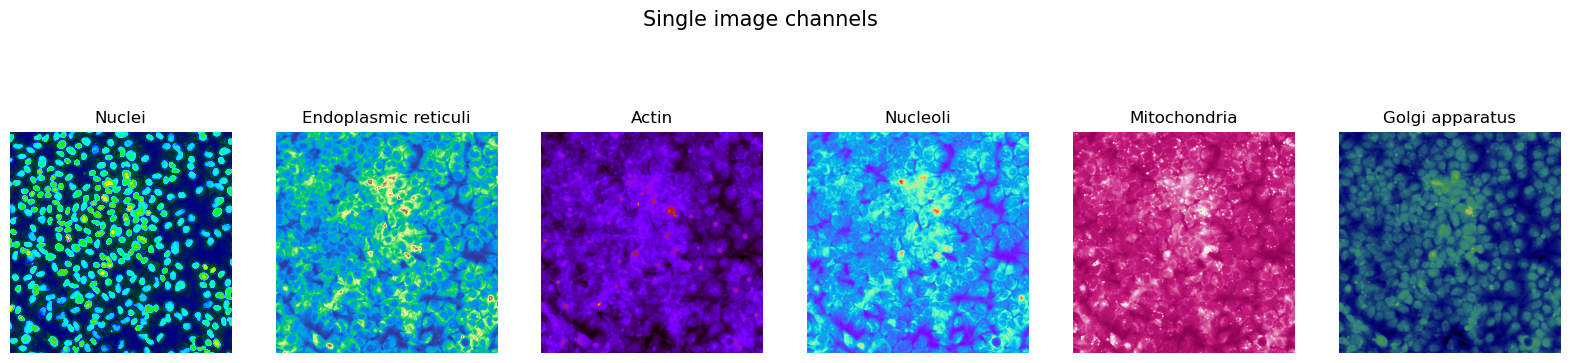

In [7]:
def plot_cell(sample_img):    
    channels = ['Nuclei', 'Endoplasmic reticuli', 'Actin', 'Nucleoli', 'Mitochondria', 'Golgi apparatus']
    cmaps = ['gist_ncar','terrain', 'gnuplot' ,'rainbow','PiYG', 'gist_earth']

    fig=plt.figure(figsize=(20, 15))
    for i in range(1,6+1):
        fig.add_subplot(1, 6, i)
        plt.imshow(sample_img[i-1, :, :,],cmap=cmaps[i-1]);
        plt.axis('off');
        plt.title(f'{channels[i-1]}')
    fig.suptitle("Single image channels", y=0.65, fontsize=15)
    plt.show()
    
## Let's looking on image channels
plot_cell(sample)

In [8]:
# Loading libraries
import sys

package_path = '../input/efficientnet/efficientnet-pytorch/EfficientNet-PyTorch/'
sys.path.append(package_path)

In [9]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... - \ done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=cec2ec2a862781a7779eb670bfb89a436a82e4349c18690805f43363c193dab0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [10]:
# Loading libraries
import sys
from efficientnet_pytorch import EfficientNet

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

In [11]:
import re

In [12]:
class CellDataset(Dataset):
    def __init__(self, df, img_dir, site=1, transforms=None):
        self.df = df
        self.img_dir = img_dir
        self.site = site
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        exp, well, plate = self.df.loc[idx,['experiment', 'well', 'plate']].values
        img_channels = [np.array(Image.open(os.path.join(self.img_dir,
                                             exp,
                                             f'Plate{plate}',
                                             f'{well}_s{self.site}_w{channel}.png')), 
                                          dtype=np.float32) for channel in range(1,7)]
        
        one_img = np.stack([channel for channel in img_channels],axis=2)
        
        if self.transforms is not None:
            one_img = self.transforms(one_img)
        if self.img_dir == '../input/recursion-cellular-image-classification/train/':
            sirna_value = self.df.loc[idx, 'sirna']
            sirna_value = re.sub("[^0-9]", "", sirna_value)
            return one_img, int(sirna_value)
        else:
            return one_img
                                 

In [13]:
# Augmentations for data
aug = transforms.Compose([
      # transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.485, 0.456, 0.456, 0.406, 0.406],
                                 std=[0.229, 0.229, 0.225, 0.225, 0.224, 0.224])
])

# Dataset & data loaders
dataset = CellDataset(df=train_df, img_dir='../input/recursion-cellular-image-classification/train/', transforms=aug)
train_loader = DataLoader(dataset=dataset, batch_size=15, shuffle=True)

test_dataset = CellDataset(df=test_df, img_dir='../input/recursion-cellular-image-classification/test/', transforms=aug)
test_loader = DataLoader(dataset=test_dataset, batch_size=15, shuffle=False)

In [14]:
#train_loader checking
data, target = next(iter(train_loader))
print(data.shape, target.shape)

torch.Size([15, 6, 512, 512]) torch.Size([15])


In [15]:
#test_loader checking
test_data = next(iter(test_loader))
print(test_data.shape)

torch.Size([15, 6, 512, 512])


In [16]:
data, target = next(iter(train_loader))
print('Dimension:', data.shape, ",", target.shape)
print('Datatype: ', data.type(), ",", target.type())
print('First target element:', target[0])


Dimension: torch.Size([15, 6, 512, 512]) , torch.Size([15])
Datatype:  torch.FloatTensor , torch.LongTensor
First target element: tensor(870)


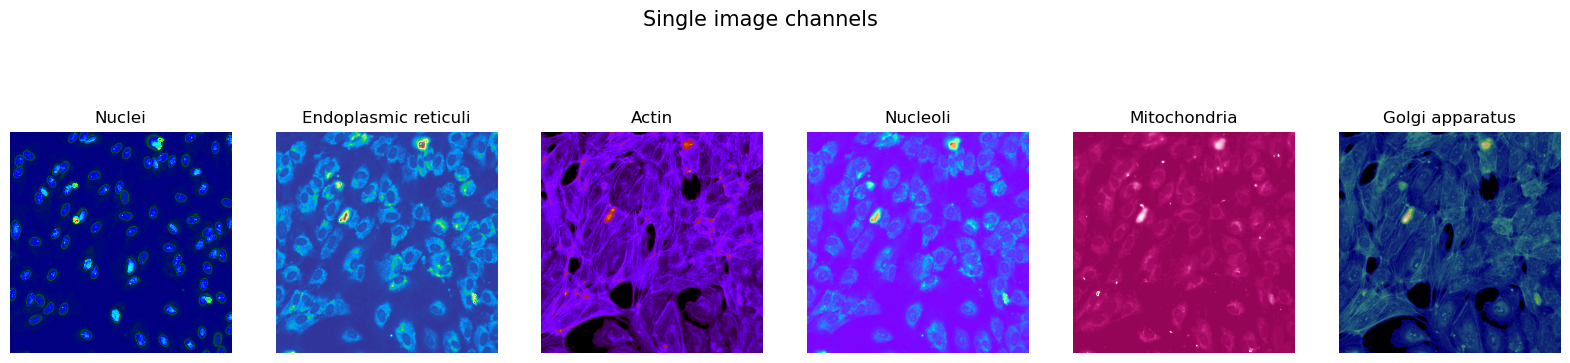

In [17]:
plot_cell(data.numpy()[1,:,:,:])

In [18]:
# Model parameters
num_epochs = 10
total_step = len(train_loader)
in_ch = 6
lr = 0.001

In [19]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1108)

# Changes count input channels of our model
trained_kernel = model._conv_stem.weight
new_conv = nn.Sequential(nn.Conv2d(in_ch, 32, kernel_size=(3,3), stride=(2,2), bias=False),
            nn.ZeroPad2d(padding=(0, 1, 0, 1)))
with torch.no_grad():
    new_conv[0].weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)]*6, dim=1)
model._conv_stem = new_conv
model = model.cuda()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 145MB/s]


Loaded pretrained weights for efficientnet-b0


In [20]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [22]:
torch.cuda.is_available()

True

In [23]:
import torch

# Set CUDA_LAUNCH_BLOCKING=1
torch.backends.cuda.matmul.allow_tf32 = False
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

for epoch in range(num_epochs):
    for batch_i, (data, target) in enumerate(train_loader):
        # Move data and target to GPU
        data = data.cuda()
        target = target[:, 0].long().cuda()

        # Rest of your code...
        outputs = model(data)
        loss = criterion(outputs, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                 .format(epoch+1, num_epochs, batch_i+1, total_step, loss.item()))
torch.save(model.state_dict(), 'model.pt')

IndexError: too many indices for tensor of dimension 1